##### System Libraries

In [1]:
import os
import subprocess
import logging
import re
import copy
import time
import math
import json
import pickle

##### Required Libraries

In [2]:
try:
    import numpy
except ModuleNotFoundError:
    os.system('pip install numpy')
    import numpy
try:
    import scapy
except ModuleNotFoundError:
    os.system('pip install scapy')
    import scapy
try:
    import tqdm
except ModuleNotFoundError:
    os.system('pip install tqdm')
    import tqdm
try:
    import requests
except ModuleNotFoundError:
    os.system('pip install requests')
    import requests
try:
    import sklearn
except ModuleNotFoundError:
    os.system('pip install scikit-learn')
    import sklearn
try:
    import matplotlib
except ModuleNotFoundError:
    os.system('pip install matplotlib')
    import matplotlib
    
logging.getLogger("requests").setLevel(logging.INFO)
logging.getLogger("urllib3").setLevel(logging.INFO)

import scapy.plist
from scapy.all import rdpcap
from tqdm import trange,tqdm

### Analyzer

#### Minor Function Breakdowns
---
##### Generate_Logger
Generates a logger with default parameters for logging critical components and debugging, default mode is INFO, for debugging change it to DEBUG
##### Generate Self IPs
Generates a list of IPs assigned to current device according to a protocol list. Uses 'ipconfig' from command prompt to get info.
##### List Initializer [V2]
Helper function to shorten and simplify initializing and re-initializing lists with values. Avoids creating lists within lists if used correctly.

##### Read JSON [V2] #deprecated
Reads a JSON file from the provided directory with the filename.(extension). Can work without the filename extension, will throw error if file doesn't exist.
##### Read List [V2] #deprecated
Reads a PKL file from the provided directory with the filename.(extension). Can work without the filename extension, will throw error if file doesn't exist.
##### Write JSON [V2]
Creates a json file with the dictionary at the directory. Can work without filename extenstion.
##### Write List [V2]
Creates a pkl file with the dictionary at the directory. Can work without filename extenstion.
##### Remove Reserved IPs
Removes IPs that belong in the reserved ranges from the provided list. '192.168.' range is excluded.
##### PCAP_Input [V1.5]
Takes a pcap file as input and returns and stores it in memory
##### Generate Unique IPs [V2]
Generates a list of unique IPs found in the PCAP data (excluding self IPs)
##### Query IPs [V2]
Requests IP information from ip-api through requests, and stores the received data in a list
##### Generate Summary [V1.1]
Summarizes the data in a neater form from ip-api
##### Trace IPs
Traces the IPs and returns the output

To-Do

.pkl expection in PCAP Input

In [ ]:

class Analyzer:
    if True:
        #Initialization of the logger, have to do it here, else it breaks stuff
        logger=logging.getLogger
        stored_logger_level=[logging.INFO]
        stored_protocol_list=["IPv4","IPv6"]

        stored_pcap_data=[]
        stored_path=[]
        stored_directory=[]
        
        stored_transmission_time=[]
        
        stored_self_ips=[]
        stored_unique_ips=[]
        stored_blocked_ips=[]

        stored_queried_data=[]
        stored_flow=[]
        stored_flow_rate=[]
        
    def __init__(self,path,protocol_list=stored_protocol_list,
                 query=True,query_amount=20,remove_reserved=True,forced=False,verbose=True):
        if True:
            self.logger=self.Generate_Logger(filename='AnalysisCore.log')
            logging.getLogger("requests").setLevel(logging.INFO)
            self.Generate_Self_IPs(protocol_list=protocol_list)
            self.PCAP_Input(path)
            self.Get_Transmission_Time()
            self.Generate_Unique_IPs(remove_reserved=remove_reserved,forced=forced)
            if query==True:
                self.Query_IPs(amount=query_amount,forced=forced,verbose=verbose)
    def Generate_Logger(self,filename='default_logger_name.log'): 
        logging.basicConfig(filename=filename,format='%(asctime)s - %(levelname)s: %(message)s',
                            datefmt='%Y-%m-%d %H:%M:%S',filemode='w',level=self.stored_logger_level[0])
        logger=logging.getLogger()
        logger.debug('Logger initialized.')
        return logger
    def Generate_Self_IPs(self,protocol_list=stored_protocol_list):
        self.logger.info("Generating self IPs with protocols, "+str(protocol_list))
        self_ips=[]
        process=subprocess.Popen(['ipconfig'],stdout=subprocess.PIPE,text=True,shell=True)
        for line in process.stdout:
            for protocol in protocol_list:
                if re.search(protocol,line.strip()):
                    self_ips.append(line.strip()[line.strip().find(':')+2:])
        self.List_Initializer(self.stored_self_ips,self_ips)
        self.logger.debug('Stored self IPs in stored_self_ips '+str(self_ips))
        return self_ips
    def List_Initializer(self,input_list,input_param):
        if isinstance(input_param,list) or isinstance(input_param,scapy.plist.PacketList):
            input_list.clear()
            for item in input_param:
                input_list.append(item)
        else:
            input_list.clear()
            input_list.append(input_param)

    def Read_JSON(self,directory,filename): #deprecated
        name, ext=os.path.splitext(filename)
        if os.path.exists(f'{directory}/{name}.json'): #if the file exists,
            self.logger.debug(f'Reading JSON from {directory}/{filename}') 
            with open(f'{directory}/{name}.json') as file: #then open it
                data=json.load(file) #save it
                return data #return it
        else:
            self.logger.error(f'Trying to open {filename} as JSON')
    def Read_List(self,directory,filename): #deprecated
        name, ext=os.path.splitext(filename)
        if os.path.exists(f'{directory}/{name}.pkl'): #if the file exists,
            self.logger.debug(f'Reading PKL from {directory}/{filename}')
            with open(f'{directory}/{name}.pkl','rb') as file: #then open it
                data=pickle.load(file) #save it
                return data #return it
        else:
            self.logger.error(f'Trying to open {filename} as PKL')
    def Write_JSON(self,dictionary,directory,filename):
        name, ext=os.path.splitext(filename)
        if ext!='.json': #make sure we are writing a json
            if ext!='':
                self.logger.error(f'Trying to write {filename} as {ext} is not JSON')
                return
        os.makedirs(directory,exist_ok=True) #make sure the directory exists, if it does not, create it
        self.logger.debug(f'Writing JSON at {directory}/{name}.json')
        with open(f'{directory}/{name.replace(':','')}.json','w') as file:  #create a file
            json.dump(dictionary,file,indent=4) #dump the dictionary in the file
    def Write_List(self,list,directory,filename):
        name, ext=os.path.splitext(filename)
        if ext!='.pkl': #make sure we are writing a pkl
            if ext!='':
                self.logger.error(f'Trying to write {filename} as {ext} is not PKL')
                return
        os.makedirs(directory,exist_ok=True) #make sure the directory exists, if it does not, create it
        self.logger.debug(f'Writing PKL at {directory}/{name}.pkl')
        with open(f'{directory}/{name.replace(':','')}.pkl','wb') as file:  #create a file
            pickle.dump(list,file) #dump the list in the file

    def Remove_Reserved_IPs(self,ips):
        self.logger.debug(f'Removing reserved IP ranges from list')
        dot=re.escape('.')
        patterns=[f'0{dot}0{dot}0{dot}0', f'10{dot}', f'127{dot}', f'169{dot}254{dot}', f'192{dot}0{dot}0{dot}', f'192{dot}0{dot}2{dot}', f'192{dot}18{dot}', f'192{dot}19{dot}',f'192{dot}51{dot}100{dot}', f'192{dot}88{dot}99{dot}', f'203{dot}0{dot}113{dot}', f'255{dot}', f'256{dot}']+[f'100{dot}{x}{dot}' for x in range(64,128)]+[f'172{dot}{x}{dot}' for x in range(16,32)]+[f'{x}{dot}' for x in range(224,240)]
        #self.logger.debug(patterns)
        temp=[]
        for ip in ips:
            for pattern in patterns:
                if re.match(pattern,ip):
                    self.logger.debug(f'Pruning {ip} with {pattern}')
                    temp.append(ip)
        for ip in ips:
            if re.search('::',ip):
                self.logger.debug(f'Pruning IPv6 IP {ip}')
                temp.append(ip)
        for temp_ip in temp:
            ips.remove(temp_ip)
        self.logger.info(f'Removed {temp}')
        return ips        
    def Get_Transmission_Time(self,pcap_data=stored_pcap_data):
        self.logger.debug(f'Calculating transmission time.')
        time=math.floor(pcap_data[-1].time-pcap_data[0].time)
        self.List_Initializer(self.stored_transmission_time,time)
        return time

    def PCAP_Input(self,path):
        directory=path[:path.find('.')]
        self.List_Initializer(self.stored_path,path)
        self.List_Initializer(self.stored_directory,directory)
        file_size=math.ceil(os.path.getsize(path)/math.pow(1024,2))
        print(f'Reading PCAP Data. [{file_size} MB]')
        self.logger.info(f'Reading PCAP data [{file_size} MB] from path, "{path}"')
        pcap_data=rdpcap(path)
        self.List_Initializer(self.stored_pcap_data,pcap_data)
        self.logger.debug(f'Stored {path} data in stored_pcap_data.')
        return pcap_data

    def Generate_Unique_IPs(self,pcap_data=stored_pcap_data,self_ips=stored_self_ips,remove_reserved=True,verbose=True,forced=False,save=True):
        unique_ips=[]
        directory=self.stored_directory[0]
        filename='unique_ips.pkl'
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing unique_ips data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(self.stored_unique_ips,read_list)
                if verbose:
                    print(f'Found unique_ips data. [{len(read_list)}]')
                return read_list
            else:
                data_not_found=True
        if (forced or data_not_found): #generate data
            self.logger.info('Extracting Unique IPs from PCAP Data.')
            blocked_ips=self_ips.copy()
            packets=pcap_data
            if verbose:
                for packet in tqdm(packets,desc='Analyzing packets for unique IPs'):
                    flag=0
                    try:
                        for ip in blocked_ips:
                            if packet.payload.dst==ip:
                                flag=1
                        if flag==0:
                            blocked_ips.append(packet.payload.dst)
                            unique_ips.append(packet.payload.dst)
                    except AttributeError:
                        broadcast_temp='256.256.256.256'
                        for ip in blocked_ips:
                            if ip==broadcast_temp:
                                flag=1
                        if flag==0:
                            blocked_ips.append(broadcast_temp)
                            unique_ips.append(broadcast_temp)
            else:
                for packet in packets:
                    flag=0
                    try:
                        for ip in blocked_ips:
                            if packet.payload.dst==ip:
                                flag=1
                        if flag==0:
                            blocked_ips.append(packet.payload.dst)
                            unique_ips.append(packet.payload.dst)
                    except AttributeError:
                        broadcast_temp='256.256.256.256'
                        for ip in blocked_ips:
                            if ip==broadcast_temp:
                                flag=1
                        if flag==0:
                            blocked_ips.append(broadcast_temp)
                            unique_ips.append(broadcast_temp)
            if remove_reserved==True:
                self.Remove_Reserved_IPs(unique_ips)
            if save==True:
                self.Write_List(unique_ips,directory,'unique_ips')
            self.List_Initializer(self.stored_unique_ips,unique_ips)
        self.logger.debug('Stored unique IPs in stored_unique_ips.')
        return unique_ips
    def Calc_Flow(self,pcap_data=stored_pcap_data,amount=0):
        
        flow=[]
        for ip in self.Generate_Unique_IPs(remove_reserved=True,verbose=False,save=False,forced=True): #initialize with all the unique ips except self ips
            flow.append([ip,0,0])
        if amount==0:
            amount=len(pcap_data)
        self.logger.info(f'Calculating flow')
        for packet in pcap_data[:amount]: #for every packet
            for self_ip in self.stored_self_ips: #for every self ip
                try:
                    if packet.payload.dst==self_ip: #check if payload destination is self ip (download)
                        for unq_ip in flow: #for every unique ip tuple
                            try:
                                if unq_ip[0]==packet.payload.src: #if the payload source matches with the unique ip
                                    unq_ip[1]+=packet.payload.len-14 #add the payload len to stored downloaded bytes
                                    break
                            except AttributeError:
                                pass
                        break
                    else: #if the destination isnt a self ip, then it must be upload
                        for unq_ip in flow: #for every unique ip
                            try:
                                if unq_ip[0]==packet.payload.dst: #if the payload destination matches with the unique ip
                                    unq_ip[2]+=packet.payload.len-14 #add the payload len to stored uploaded bytes
                                    break
                            except AttributeError: #if removed, broadcast packets will throw errors
                                pass
                except AttributeError:
                    pass
        self.List_Initializer(self.stored_flow,flow)
        directory=self.stored_directory[0]
        if amount>=len(pcap_data):
            self.Write_List(flow,directory,'flow')
        self.logger.debug('Stored total flow in stored_flow')
        return flow
    def Calc_Flow_Rate(self,pcap_data=stored_pcap_data):
        self.logger.info('Calculating flow rates')
        trans_time=self.stored_transmission_time[0]
        flow=self.Calc_Flow(pcap_data)
        for ip_flow in flow:
            ip_flow[1]=math.trunc(float(ip_flow[1])/trans_time*100)/100
            ip_flow[2]=math.trunc(float(ip_flow[2])/trans_time*100)/100
        flow_rate=flow
        self.List_Initializer(self.stored_flow_rate,flow_rate)
        self.Write_List(flow_rate,self.stored_directory[0],'flow_rate')
        self.logger.debug('Stored flow rate in stored_flow_rate')
        return flow_rate
    
    def Query_IP(self,ip):
        self.logger.debug(f'Querying for IP {ip}')
        response=requests.get(f"http://ip-api.com/json/{ip}")
        data=response.json()
        return data    
    def Query_IPs(self,ips=stored_unique_ips,amount=45,forced=False,verbose=True):
        queried_data=[]
        to_be_queried=ips.copy()
        directory=self.stored_directory[0]
        filename='queried_data.pkl'
        incomplete=False
        data_not_found=False
        if not forced: #load existing data if found
            if os.path.exists(f'{directory}/{filename}'): #if existing data is found
                self.logger.info(f'Found existing query data at {directory}/{filename}')
                read_list=self.Read_List(directory,filename)
                self.List_Initializer(queried_data,read_list)
                if len(read_list)<len(to_be_queried):
                    incomplete=True
                if verbose:
                    print(f'Found query data. [{len(queried_data)}]')
                    if incomplete:
                        print(f'Data is incomplete. [{len(to_be_queried)-len(read_list)}]')
            else:
                data_not_found=True
        if (forced or incomplete or data_not_found):
            if incomplete: #if incomplete, prune
                self.logger.debug(f'Pruning IPs')
                prune=[]
                for query in queried_data: #for every queried IP
                    for ip in to_be_queried: #for every IP to be queried
                        if query[0]==ip: #check if the IP has already been queried
                            prune.append(ip) #add the IP to a pruning list
                            break
                for pruning_ip in prune: #prune the IPs
                    to_be_queried.remove(pruning_ip)
            self.logger.info(f'Querying IPs [{len(to_be_queried)}]')
            if verbose:
                for ip in tqdm(to_be_queried[:min(amount,45)],desc='Querying IPs'):
                    response=self.Query_IP(ip)
                    temp=[ip]
                    temp.append(response)
                    queried_data.append(temp)
            else:
                print(f'Query_IPs verbose=false incomplete')
            self.Write_List(queried_data,directory,filename)
        self.List_Initializer(self.stored_queried_data,queried_data)
        self.logger.debug('Stored queried data in stored_queried_data')
        return queried_data
    
    def Generate_Summary(self,data=stored_queried_data):
        self.logger.info(f'Summarizing data.')
        summarized=[]
        for query_data in data:
            temp={}
            query=query_data[1]
            if query['status']=='success':
                temp['Location']=f"{query['city']}, {query['regionName']}, {query['country']} | Lat: {query['lat']}, Long: {query['lon']}"
                temp['Organization']=f"{query['as']}, {query['org']}, {query['isp']}"
                temp['IP']=f"{query['query']}"
            elif query['status']=='fail':
                temp['Location']=f'Unknown [Failed]'
                temp['Organization']=f'Unknown [Failed]'
                temp['IP']=f"{query['query']}"
            summarized.append(temp)
        self.logger.debug('Summarizing completed.')
        return summarized
    def Generate_Dataset(self):
        self.logger.info(f'Generating dataset')
        dataset=[] #[{ID1,IP},{},{},{}]
        unique_ips=self.stored_unique_ips.copy()
        
        
    def Trace_IPs(self,ips=stored_unique_ips,amount=99,hops=20,timeout=1000):
        self.logger.info(f'Tracing IPs {ips[:amount]}')
        processes=[]
        for ip in ips[:amount]:
            processes.append(subprocess.Popen(["tracert","-h",str(hops),"-w",str(timeout),ip],
                                              stdout=subprocess.PIPE,text=True,shell=True))
        time.sleep(math.ceil(hops*(timeout/1000)*3.75*(1+amount*0.001)))
        outputs_temp=[]
        for process in processes:
            outputs_temp.append(process.stdout)
        output_cleaned=[]
        for output in outputs_temp:
            temp=[]
            for line in output:
                if line.strip()!='':
                    temp.append(line.strip())
            output_cleaned.append(temp)
        return output_cleaned
    
    def Query_Unique_IPs(self,unique_ips=stored_unique_ips,amount=20): #deprecated
        directory=self.stored_directory[0]
        if os.path.exists(f'{directory}/'):
            pass
        queried_unique_ips=[]
        to_be_queried=unique_ips.copy()
        
        self.logger.info(f'Querying unique IPs.')
        
        
        if len(self.stored_queried_ips)!=0: #if data already exists, then read it
            self.logger.debug(f'Found queried data. Pruning query list')
            for query in self.stored_queried_ips:   #prune the IPs to be queried
                for ip in to_be_queried:
                    try:
                        if query['query']==ip:
                            to_be_queried.remove(ip)
                    except KeyError:
                        pass
        if len(to_be_queried)!=0: #only if there are IPs to be queried, then query
            for ip in tqdm(to_be_queried[:min(amount,45)],desc='Querying IPs'):
                response=self.Query_IP(ip)
                queried_unique_ips.append(response)
                self.Write_JSON(response,self.stored_path[0][:self.stored_path[0].find('.')],response['query'])
        else:
            self.logger.info(f'All unique IPs are queried')
            print(f'All unique IPs are already queried')
            temp={'status':'Completed',
                  'amount':f'{len(self.stored_queried_ips)} IPs',
                  'time':f'{self.stored_transmission_time[0]} seconds'}
            self.Write_JSON(temp,self.stored_path[0][:self.stored_path[0].find('.')],'status')
        if len(self.stored_queried_ips)!=0: #if theres already data then append to it, else initialize it, if removed it will always overwrite data
            for query in queried_unique_ips:
                self.stored_queried_ips.append(query)
        else:
            self.List_Initializer(self.stored_queried_ips,queried_unique_ips)
        return queried_unique_ips

In [4]:
A=Analyzer('PCAP Data/720S-Down-Spo-Misc-Idling.pcap',query=True,query_amount=45,remove_reserved=False)

Reading PCAP Data. [4 MB]


Querying IPs: 100%|██████████| 45/45 [00:31<00:00,  1.44it/s]


In [5]:
A.Generate_Summary()

[{'Location': 'Toronto, Ontario, Canada | Lat: 43.6532, Long: -79.3832',
  'Organization': 'AS13335 Cloudflare, Inc., Cloudflare, Inc., Cloudflare, Inc.',
  'IP': '162.159.134.234'},
 {'Location': 'Kansas City, Missouri, United States | Lat: 39.0997, Long: -94.5785',
  'Organization': 'AS15169 Google LLC, Google Cloud, Google LLC',
  'IP': '35.186.224.45'},
 {'Location': 'Unknown [Failed]',
  'Organization': 'Unknown [Failed]',
  'IP': '239.255.255.250'},
 {'Location': 'Unknown [Failed]',
  'Organization': 'Unknown [Failed]',
  'IP': '192.168.0.1'},
 {'Location': 'Stockholm, Stockholm, Sweden | Lat: 59.3293, Long: 18.0686',
  'Organization': 'AS16509 Amazon.com, Inc., AWS EC2 (eu-north-1), Amazon.com, Inc.',
  'IP': '51.21.215.65'},
 {'Location': 'Unknown [Failed]',
  'Organization': 'Unknown [Failed]',
  'IP': '256.256.256.256'},
 {'Location': 'Maharashtra, Maharashtra, India | Lat: 19.5, Long: 76',
  'Organization': 'AS32590 Valve Corporation, Valve Corporation, Valve Corporation',
 

In [6]:
A.Calc_Flow_Rate()

[['162.159.134.234', 799.02, 350.95],
 ['35.186.224.45', 10.91, 13.44],
 ['192.168.0.1', 51.21, 91.06],
 ['51.21.215.65', 73.84, 88.21],
 ['155.133.224.23', 27.66, 22.87],
 ['34.110.207.168', 15.37, 63.91],
 ['35.186.227.140', 10.38, 53.47],
 ['157.240.1.60', 20.96, 41.55],
 ['192.168.0.255', 0.0, 8.77],
 ['20.198.167.116', 13.07, 7.21],
 ['104.199.241.202', 0.87, 10.98],
 ['35.186.224.40', 3.79, 20.21],
 ['35.186.224.22', 70.73, 304.7],
 ['35.186.224.24', 28.22, 100.64],
 ['104.18.32.47', 0.34, 1.93],
 ['72.25.64.32', 1.15, 4.78],
 ['4.213.25.240', 0.43, 1.29],
 ['52.178.17.2', 2.03, 7.67],
 ['142.250.196.46', 0.21, 1.42],
 ['34.149.100.209', 2.5, 10.73],
 ['202.78.239.186', 6.49, 4.85],
 ['51.116.253.170', 47.95, 43.45],
 ['13.61.46.223', 38.17, 36.49],
 ['162.159.137.232', 19.28, 132.97],
 ['40.126.17.132', 0.03, 0.28],
 ['162.159.128.233', 34.36, 95.05],
 ['185.199.110.133', 10.39, 6.13],
 ['13.107.5.93', 42.69, 38.86],
 ['172.67.177.39', 471.12, 30.65],
 ['20.207.73.85', 13.75, 10

In [7]:
A.stored_pcap_data[0].payload.dst

'192.168.0.128'

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# Generate sample data
#X, y_true = make_blobs(n_samples=10, centers=4, cluster_std=0.60, random_state=0)

# Apply KMeans
kmeans = KMeans(n_clusters=4, random_state=0)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Plot results
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X')  # cluster centers
plt.title('K-Means Clustering')
plt.show()

NameError: name 'X' is not defined

In [ ]:
X

array([[ 0.91433877,  4.55014643],
       [ 2.24310814,  0.38520622],
       [ 2.32158546,  1.09786826],
       [ 1.43289271,  4.37679234],
       [-1.22080066,  7.72314971],
       [-1.00824229,  2.47258325],
       [ 1.06269622,  5.17635143],
       [ 2.95171497,  0.7745687 ],
       [ 0.113597  ,  6.96284061],
       [-3.0586979 ,  3.31005342]])

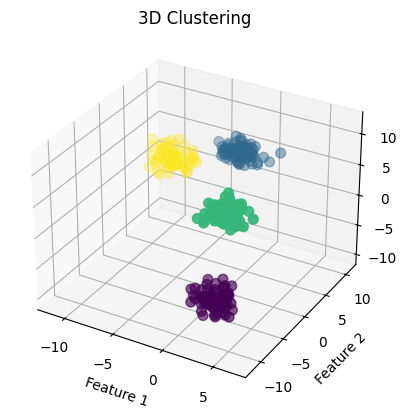

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Sample 3D data
X, _ = make_blobs(n_samples=300, centers=4, n_features=3, random_state=42)

# Clustering
kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(X)

# Plotting in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=labels, cmap='viridis', s=50)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.title('3D Clustering')
plt.show()

In [ ]:
all_ips=A.stored_self_ips+A.stored_unique_ips
output=[]
for packet in A.stored_pcap_data[:10]:
    temp=[packet.payload.src,packet.payload.dst,packet.payload.len+14]
    output.append(temp)
output

In [ ]:
A.stored_pcap_data[0].payload.dst

In [ ]:
A.stored_unique_ips

In [ ]:
summarized_trace=[]
pattern=re.escape('[')
for trace in outputs_trace:
    temp=[]
    for line in trace:
        match=re.match(r"\d",line.strip())
        if match:
            temp2=line.strip()[30:]
            if re.search(pattern,temp2):
                temp2=temp2[temp2.find('[')+1:temp2.find(']')]
            temp.append(temp2)
    summarized_trace.append(temp)
summarized_trace

In [ ]:

# unique_ips=[]
# temp=[]
# ip=A.stored_unique_ips[1]
# response=requests.get(f"http://ip-api.com/json/{ip}")
# data=response.json()
# temp.clear()
# temp.append(ip)
# temp.append(data)
# unique_ips.append(temp)
# unique_ips